# Segmenting and Clustering Neighborhoods in Toronto

#### This notebook will be used for the analysis of the different neighborhoods in the Toronto area as part of the Coursera IBM Data Science Capstone Project

In [1]:
# Import libraries
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library
from bs4 import BeautifulSoup # webscraping and parser library
print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries imported.


### The webpage contains tables.  Using the below commands, the information can be navigated and parsed correctly.
### It lists 103 cells pertaining to the FSAs (Forward Sortation Areas) or Postal Codes in Toronto.

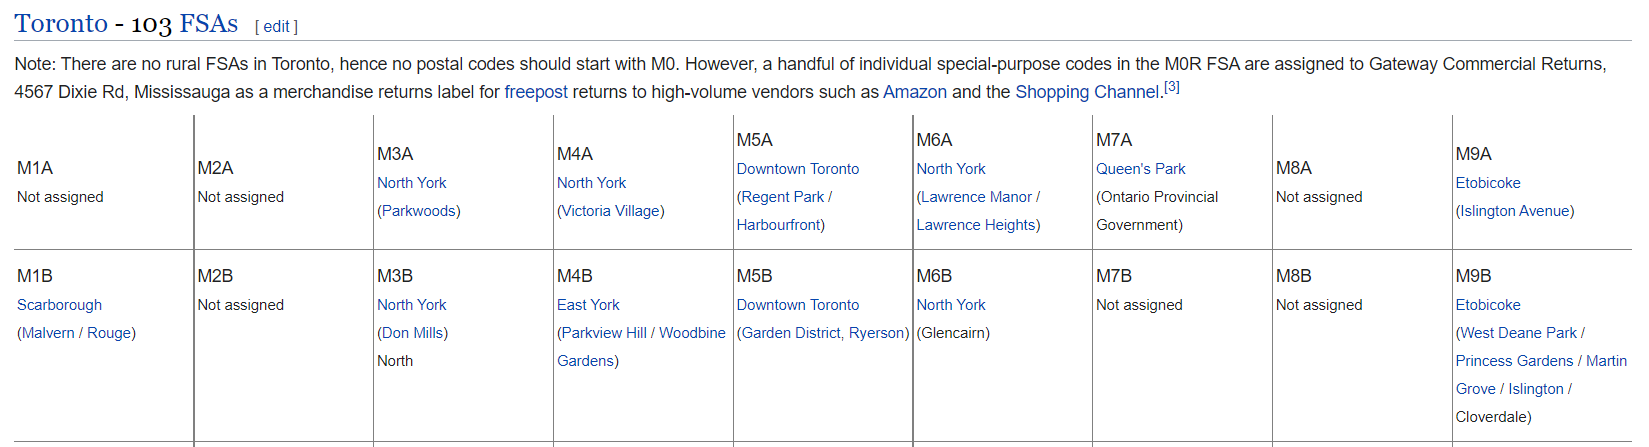

### Now to setup the notebook to locate and extract the information

In [2]:
# Using Requests and BeautifulSoup library to extract and format the data
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M' # website containing the information to use
data  = requests.get(url).text # webscrape the data and format as text
soup = BeautifulSoup(data,"html5lib")  # create a soup object using the variable 'data' html doctype
# print(soup.prettify)  # displays the content in text document

In [3]:
# find all html tables in the web page
tables = soup.find_all('table') # in html table is represented by the tag <table>

In [4]:
# number of tables found by checking the length of the tables list
len(tables)

3

### Extracting and formating the data using Pandas.

In [5]:
# Creating a data frame 'cell' which will break the data for Toronto into three columns.

cell = ['Postal Code', 'Borough', 'Neighborhood']

table_contents=[]
table=soup.find('table')
for row in table.findAll('td'): # locates a data cell within a table
    cell = {}
    if row.span.text=='Not assigned':  # skips over empty cells
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

# print(table_contents)
df=pd.DataFrame(table_contents)
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

In [6]:
#DataFrame.sort_values(by, axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last', ignore_index=False, key=None)
df = df.rename({'PostalCode': 'Postal Code'}, axis=1)
df.head(12) # Display first eleven rows.

,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government
5,M9A,Etobicoke,Islington Avenue
6,M1B,Scarborough,"Malvern, Rouge"
7,M3B,North York,Don Mills North
8,M4B,East York,"Parkview Hill, Woodbine Gardens"
9,M5B,Downtown Toronto,"Garden District, Ryerson"


In [7]:
df.shape # Size (rows) in our data table.
'>>> Displays the shape of the dataframe'
df.shape

(103, 3)

### So far the information has been extracted from Wikipedia, reviewed and parsed, and placed into a data frame.  The data frame is (103, 3) which means we have the correct amount of data.

# Part 2: Using GeoLocation Data

In [8]:
# Information regarding Geo Locator ---> https://geocoder.readthedocs.io/index.html
!pip install geocoder
import geocoder # import geocoder

/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 98 kB 12.0 MB/s eta 0:00:01


### Run this for obtaining all the coordinates
>sometimes GeoLocator is unreliable

postal_code = 1
#initialize your variable to None

lat_lng_coords = None

### Loop until you get the coordinates
while(lat_lng_coords is None):
    g = geocoder.google('{}, Toronto, Ontario'.format(postal_code))
    lat_lng_coords = g.latlng

latitude = lat_lng_coords[0]
longitude = lat_lng_coords[1]

### From the location data, a new dataframe is built.

In [14]:
# link to a csv file that has the geographical coordinates of each postal code:
postal = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs_v1/Geospatial_Coordinates.csv'
df1 = pd.read_csv(postal)
df1.sort_values(by=['Postal Code'])

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476
5,M1J,43.744734,-79.239476
6,M1K,43.727929,-79.262029
7,M1L,43.711112,-79.284577
8,M1M,43.716316,-79.239476
9,M1N,43.692657,-79.264848


### Now to combine the two dataframes and create a single dataframe for accessing

In [15]:
# Merge Toronto dataframe with the Latitude and Longitude data
resultdf = pd.merge(df, df1, on = ['Postal Code'])
display(resultdf)
#result.shape

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494
5,M9A,Etobicoke,Islington Avenue,43.667856,-79.532242
6,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
7,M3B,North York,Don Mills North,43.745906,-79.352188
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937


### Setup and verify locator

In [16]:
# Setup key and explorer using geolocator
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="tor_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of',address,'are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Toronto, ON are 43.6534817, -79.3839347.


In [17]:
# Setup key and explorer using geolocator
address = 'Downtown Toronto, ON'

geolocator = Nominatim(user_agent="tor_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of',address,'are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Downtown Toronto, ON are 43.6563221, -79.3809161.


### Create map of Toronto using latitude and longitude values

In [18]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10, tiles='CartoDB dark_matter')

# add markers to map
for lat, lng, label in zip(resultdf['Latitude'], resultdf['Longitude'], resultdf['Borough']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

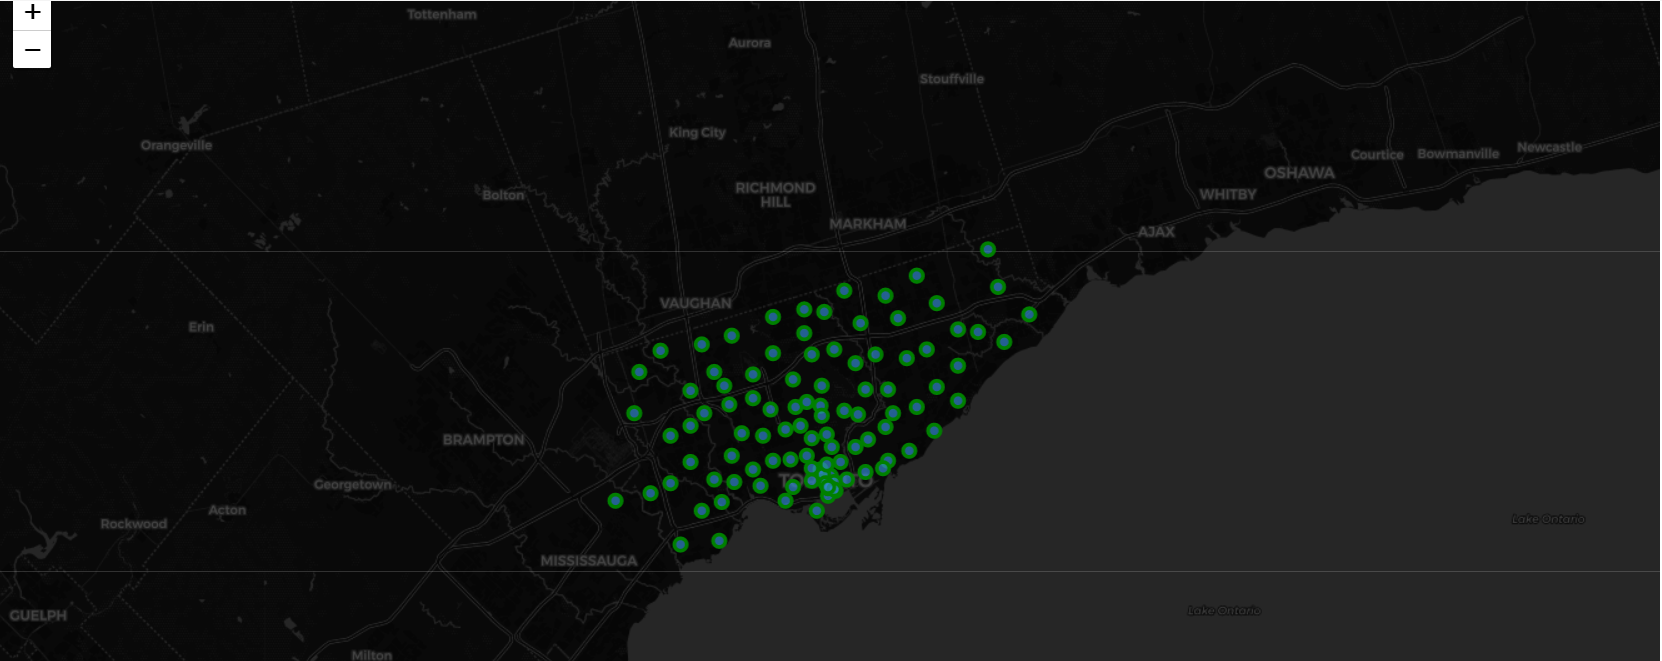

### Let's explore Downtown Toronto.  Using the same process as before.

In [20]:
dtt_data = resultdf[resultdf['Borough'] == 'Downtown Toronto'].reset_index(drop=True)  # From the data frame utilzing Borough, with search criteria Downtown Toronto.
display(dtt_data) # displays the table
dtt_data.shape # size of table

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
2,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
3,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306
4,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383
5,M6G,Downtown Toronto,Christie,43.669542,-79.422564
6,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568
7,M5J,Downtown Toronto,"Harbourfront East, Union Station, Toronto Islands",43.640816,-79.381752
8,M5K,Downtown Toronto,"Toronto Dominion Centre, Design Exchange",43.647177,-79.381576
9,M5L,Downtown Toronto,"Commerce Court, Victoria Hotel",43.648198,-79.379817


(17, 5)

In [21]:
# create map of Downtown Toronto using latitude and longitude values
map_dtt = folium.Map(location=[latitude, longitude], zoom_start=11, tiles='CartoDB dark_matter')

# add markers to map
for lat, lng, label in zip(dtt_data['Latitude'], dtt_data['Longitude'], dtt_data['Borough']):  # df1 contains our lat/lon values with zip.  dtt_data contains the borough names.
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_dtt)  
    
map_dtt

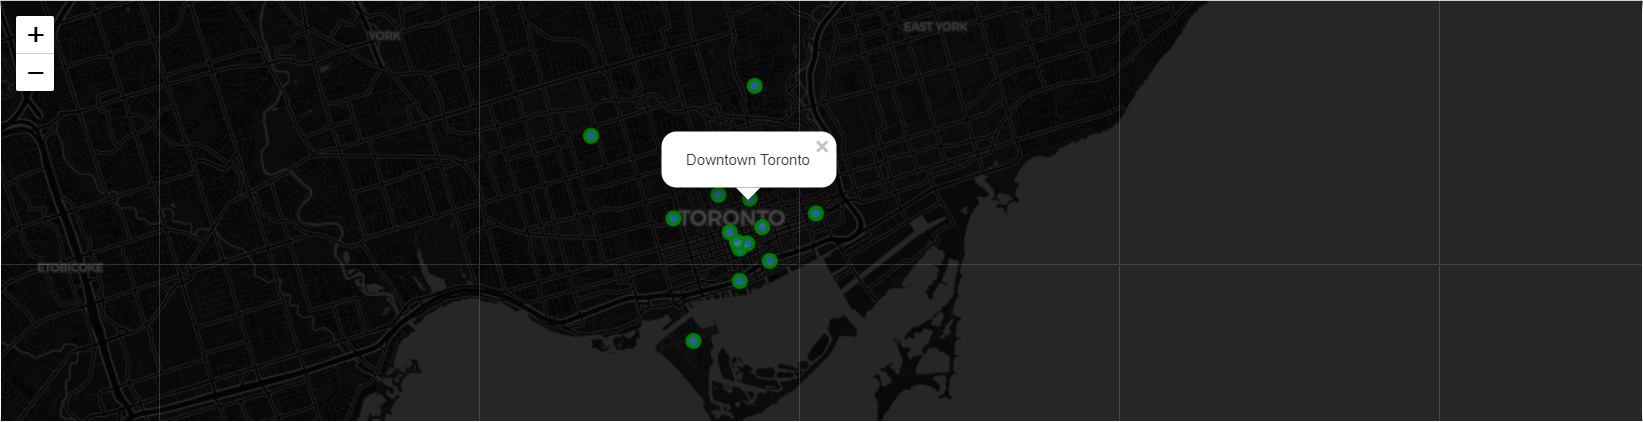

### From our initial results downtown Toronto has different locations consisting of districs within the Toronto area.  To include Chinatown, Financial, and Distillery districts to name a few.

### Setup credentials for FourSquare API

In [22]:
# The code was removed by Watson Studio for sharing.

### Display our neighborhoods again and setup the locator

In [ ]:
# Display the table for downtown Toronto data
dtt_data.head(11)

In [ ]:
# Locate specific neighborhood and coordinates in the array/table
dtt_data.loc[0, 'Neighborhood']


# Part 3: Neighborhood Clustering and Analysis.
#Now let's begin to research what there is to do around each neighborhood.